# Peaking test
This notebook uses the `EmissionsPeakTest` class, defined in the scripts section, to explore what level of reduction in Global Fossil CO2 emissions would be necessary to declare a peak with confidence.

Key steps are
- Load data into the EmissionsPeakTest class
- Characterise the noise (key choices here about whether to do the noise around a single trendline, or break the timeseries into a series of segments for analysis)
- Load test data for the future, and calculate the trendline for this data
- Do a bootstrap test to see how likely it is that outturn data with this trendline could actually be produced by a flat trend (H0 is that the trend=0), with just the noise contributing this variation

## Load packages

In [1]:
%reload_ext autoreload
%autoreload 2

In [1]:
import sys
sys.path.append('../scripts')

from peak_tester import EmissionsPeakTest
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
import os, sys

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w', encoding='utf-8')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

## Fossil co2 implementation

### Initialise peaker and characterise noise

In [3]:
peak_tester = EmissionsPeakTest()
peak_tester.load_historical_data(
    'gcb_hist_co2.csv', region='WLD', year_range = range(1970,2025))

Loaded historical data: 1970-2024
Data points: 55


### Basic analysis
- Characterise noise
- Add test data and bootstrap
- Visualise results

In [4]:
peak_tester.characterize_noise(method='linear_w_autocorrelation') # choose 'normal', 't-dist' or 'empirical'. If 't-dist' can choose t_df or leave to calculate
peak_tester.create_noise_generator()


using normal distribution to calculate noise
Autocorrelation analysis:

  Lag-1 autocorr: 0.060
  Residual σ (post-autocorrelation): 565.3
  Has significant autocorr: False
  Likelihood of autocorr: 0.3491421206678167
Noise characterization complete:
  Method used: linear_w_autocorrelation
Using white noise generator with mean=0,  σ=562.813


<function peak_tester.EmissionsPeakTest.create_noise_generator.<locals>.white_noise_generator(size: int, initial_value: float = 0) -> numpy.ndarray>

In [5]:
# Testing that with a flat trend, it gives ~50% chance that emissions have actually peaked
peak_tester.set_test_data([
        (2024, peak_tester.historical_data.iloc[-1,1]),
        (2025, peak_tester.historical_data.iloc[-1,1]),
        (2026, peak_tester.historical_data.iloc[-1,1]), 
        (2027, peak_tester.historical_data.iloc[-1,1]),
    ]).run_complete_bootstrap_test(bootstrap_method='ar_bootstrap')

Test data set: 2024-2027
Test slope: 0.00 Mt CO2 (R² = 1.000)
Recent historical trend: 326.67 Mt CO2
Running complete bootstrap test...
  Null hypothesis: zero_trend
  Bootstrap method: ar_bootstrap
  Bootstrap samples: 10000
Results:
  P-value: 0.5073
  Significant at α=0.1: False
  Effect size: -0.01 standard deviations


In [6]:
# Testing what happens with a declining trend of 1% / yr
peak_tester.set_test_data([
        (2024, peak_tester.historical_data.iloc[-1,1]),
        (2025, peak_tester.historical_data.iloc[-1,1]*0.99),
        (2026, peak_tester.historical_data.iloc[-1,1]*0.99**2), 
        # (2027, peak_tester.historical_data.iloc[-1,1]*0.99**3),
    ]).run_complete_bootstrap_test()


Test data set: 2024-2026
Test slope: -384.06 Mt CO2 (R² = 1.000)
Recent historical trend: 326.67 Mt CO2
Running complete bootstrap test...
  Null hypothesis: zero_trend
  Bootstrap method: ar_bootstrap
  Bootstrap samples: 10000
Results:
  P-value: 0.1711
  Significant at α=0.1: False
  Effect size: 0.95 standard deviations


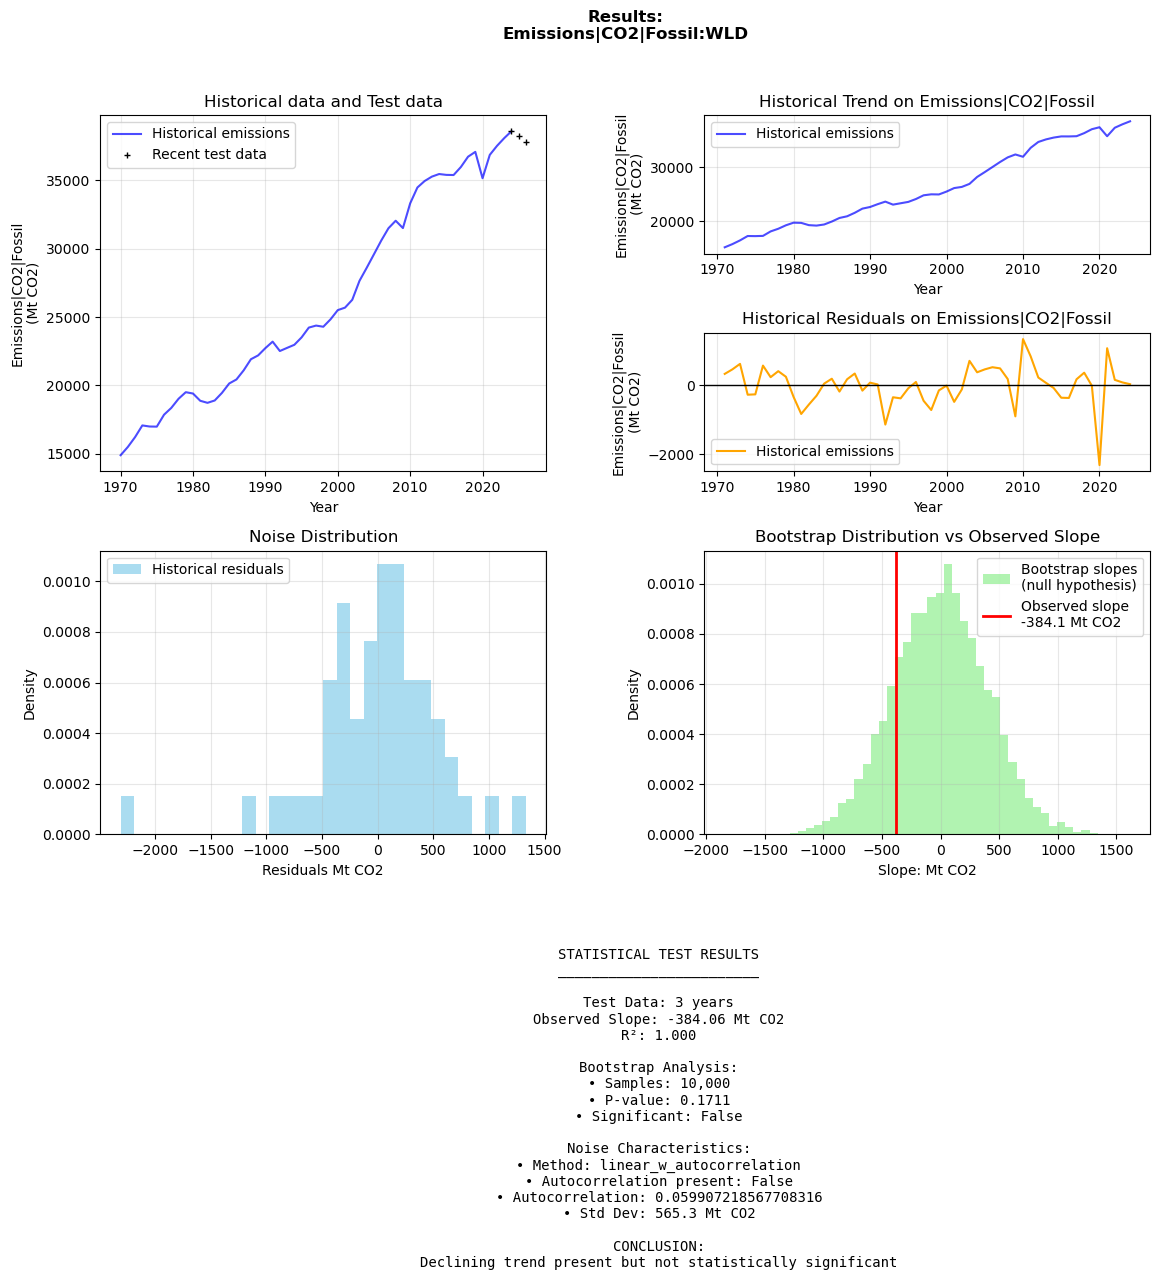

In [7]:
peak_tester.plot_analysis()

## Implementation on carbon intensity
Test applying the peak tester to carbon intensity instead, which abstracts out the GDP growth component

In [14]:
carbon_intensity_tester = EmissionsPeakTest()
carbon_intensity_tester.load_historical_data(
    'carbon_intensity_gdp.csv', region='WLD',year_range = range(1970,2025))

Loaded historical data: 1970-2024
Data points: 55


Let's assume that GDP is growing at 2% per year over a three year period. Therefore we want to test if carbon intensity is falling more than 2% per year (which would be needed to offset a GDP growth trend)

In [32]:
carbon_intensity_tester.characterize_noise(method='spline').create_noise_generator()

using normal distribution to calculate noise
Autocorrelation analysis:

  Lag-1 autocorr: 0.799
  Residual σ (post-autocorrelation): 0.0
  Has significant autocorr: True
  Likelihood of autocorr: 0.999999998693173
Noise characterization complete:
  Method used: spline
Using AR(1) noise generator with φ=0.80, mean=0.000, sigma=0.007


<function peak_tester.EmissionsPeakTest.create_noise_generator.<locals>.ar1_noise_generator(size: int, initial_value: float | None = 0) -> numpy.ndarray>

In [28]:
ci_2023 = carbon_intensity_tester.historical_data.loc[carbon_intensity_tester.historical_data.year==2023,'emissions'].squeeze()

Test data set: 2025-2027
Test slope: -0.01 kg CO2 / $ (R² = 1.000)
Recent historical trend: -0.01 kg CO2 / $
Running complete bootstrap test...
  Null hypothesis: trend of -0.008104557259846221 / yr
  Bootstrap method: ar_bootstrap
  Bootstrap samples: 10000
Results:
  P-value: 0.5170
  Significant at α=0.1: False
  Effect size: -0.06 standard deviations


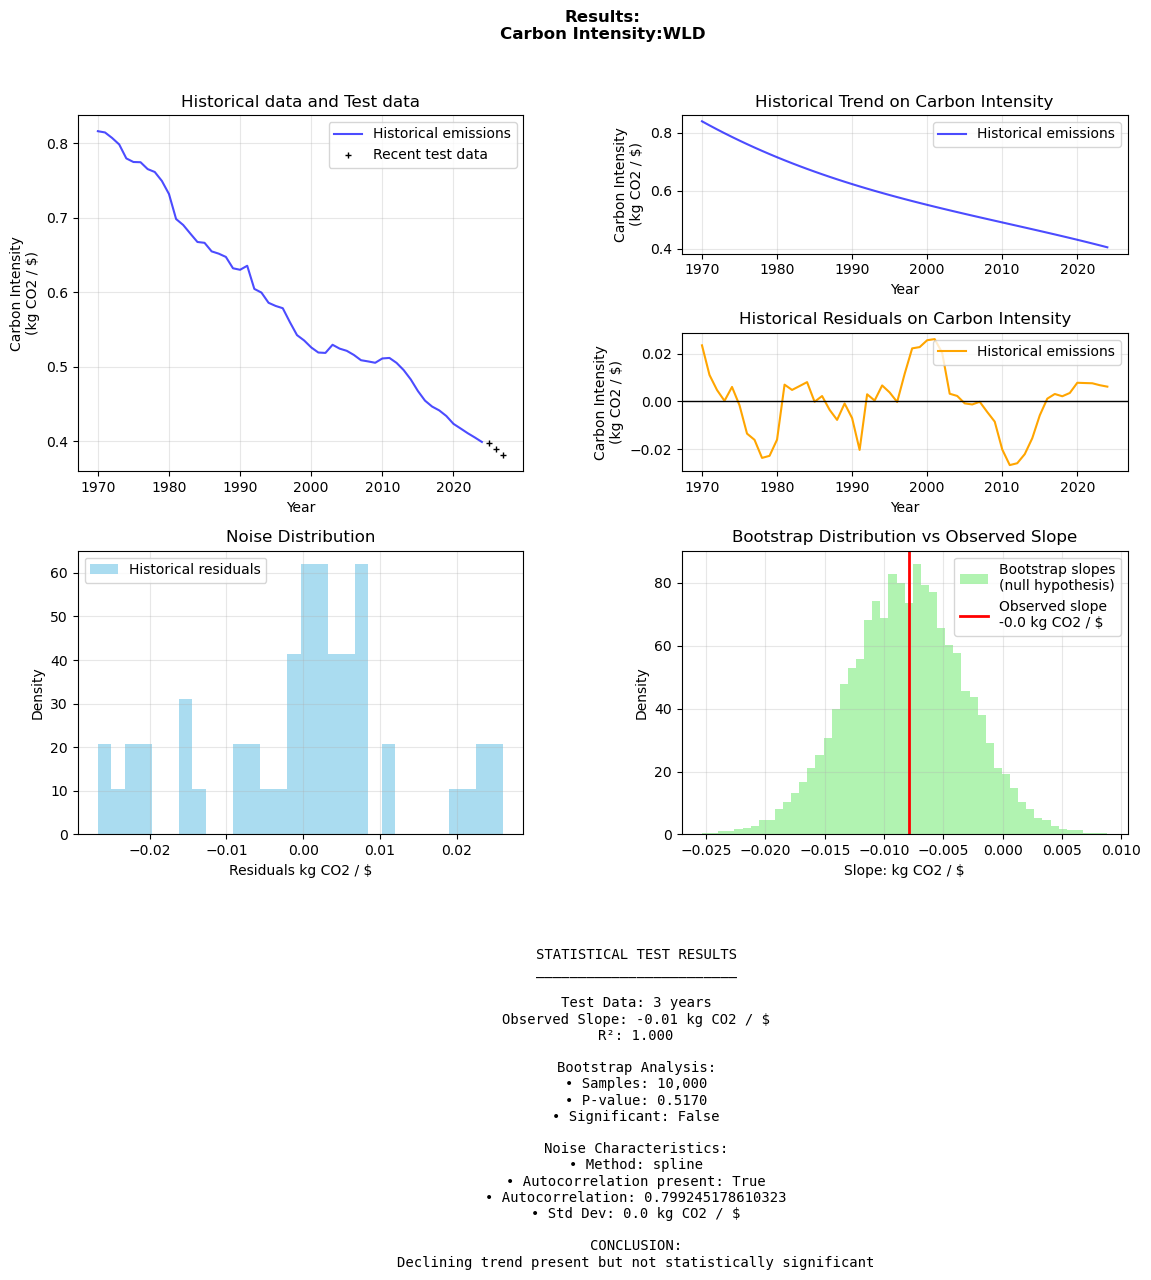

In [33]:
ci_improvement = 0.02 # % improvements per year

carbon_intensity_tester.set_test_data([
        (2025, ci_2023*(1-ci_improvement)),
        (2026, ci_2023*(1-ci_improvement)**2), 
        (2027, ci_2023*(1-ci_improvement)**3),
    ]).run_complete_bootstrap_test(bootstrap_method='ar_bootstrap',null_hypothesis=ci_2023*-0.02)

carbon_intensity_tester.plot_analysis()